## Home Credit competition

- 他のチームの結果を参考に, LightGBMの使い方, pythonコードの作成方法についてまとめる
- コメント文など適宜追加する

## References

- [Kaggle:How to LightGBM with lightgbm.cv](https://www.kaggle.com/shep312/lightgbm-harder-better-slower/code)
- [Python API](https://lightgbm.readthedocs.io/en/latest/Python-API.html)
- [roc auc score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html0)
- [1st place solution](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821)
- [2nd place solution](https://www.kaggle.com/c/home-credit-default-risk/discussion/64722)

## Winner session summary

Important thing is

- Good set of smart features
- Diverse set of base algorithms



## Import modules

In [45]:
# import module
import gc, os, sys, warnings,time
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from multiprocessing import cpu_count, Pool
from collections import defaultdict
from glob import glob
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

# set path
sys.path.append("/Users/takuto/Desktop/Home_Credit_Kaggle/py/") # for macbook
sys.path.append("/Users/takutokotsubo/Desktop/Home_Credit_Kaggle/py/") # for imac
%matplotlib notebook

## function

- @contextmanager: with文を用いて簡単に実行時間を計測できる関数を作成できる
- one-hot: デジタル回路において, 1つだけ"1"の値をとり, 他の全ての値が"0"であるようなビット列, ダミー変数化では0,1の値を用いて区別するので少し意味合いが違うことに注意
- gc.collect(): del -> gc.collect()でメモリを開放でできる

In [10]:
# Execution time measuring
@contextmanager
def timer(title):
    t0 = time.time()
    yield print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
# One-hot encoding for categorical columns with get_dummies
# not using
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df,new_columns

# preprocess all data
# not using
def read_all_data(num_rows = None, nan_as_category = False):
    df = pd.read_csv("../input/csv_imp1/all_data_train.csv", nrows = num_rows)
    test = pd.read_csv("../input/csv_imp1/all_data_test.csv", nrows = num_rows)
    df = df.append(test).reset_index()
    # Categorical features with Binary encode (0 or 1; two categories)
    # for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    #    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    del test
    gc.collect()
    return df

# LightGBM with cv, not completed !!!!!!!!!!!
def lightgbm_cv(df, num_folds, NFOLD, LOOP, debug = False):
    # parameters
    param = {
         'objective': 'binary',
         'metric': 'auc',
         'learning_rate': 0.01,
         'max_depth': 6,
         'num_leaves': 63,
         'max_bin': 255,
         'min_child_weight': 10,
         'min_data_in_leaf': 150,
         'reg_lambda': 0.5,  # L2 regularization term on weights.
         'reg_alpha': 0.5,  # L1 regularization term on weights.
         'colsample_bytree': 0.9,
         'subsample': 0.9,
         'nthread': cpu_count(),
         'bagging_freq': 1,
         'verbose':-1,
         }
    train_df = pd.read_csv("../input/csv_imp1/all_data_train.csv", nrows = num_rows)
    test_df = pd.read_csv("../input/csv_imp1/all_data_test.csv", nrows = num_rows)
    print("Starting Light GBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df; gc.collect()
    # non list
    feats = [f for f in train_df.columns if f not in ["TARGET","SK_ID_CURR","SK_ID_BUREAU","SK_ID_PREV","index"]]
    train_x, train_y, test_X = train_df[feats], train_df["TARGET"], test_df[feats]      
    dtrain = lgb.Dataset(train_x,train_y)
    gc.collect()
    # result box
    model_all = []
    y_pred = pd.Series(0, index=train_y.index)
    
    # training with cv
    for i in range(LOOP):
        gc.collect()
        ret, models = lgb.cv(param, dtrain, 9999, nfold=NFOLD,
                             early_stopping_rounds=100, verbose_eval=50, seed=i)
        model_all += models
        
# Display/plot feature importance
# maybe not need 
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances01.png')

# send message to line
def send_line(message):
    line_notify_token = 'TOKEN'
    line_notify_api = 'https://notify-api.line.me/api/notify'
    payload = {'message': message}
    headers = {'Authorization': 'Bearer ' + line_notify_token}
    requests.post(line_notify_api, data=payload, headers=headers)

# main, not completed !!!!!!!!!!
def main(debug = False):
    num_rows = 100000 if debug else None # for debug
    df = read_all_data(num_rows)
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

## Light GBM cross validation

- メモ形式
- 完成したら関数化
- 重要な特徴量の抽出も可能にする

In [11]:
# function para
LOOP = 5
NFOLD = 5 # good set: 7
num_rows = None # good set: None

In [27]:
# input data
## imp_csv0
train_df = pd.read_csv("../input/csv_imp0/all_data_train.csv", nrows = num_rows)
test_df = pd.read_csv("../input/csv_imp0/all_data_test.csv", nrows = num_rows)
## imp_csv1
# train_df = pd.read_csv("../input/csv_imp1/all_data_train.csv", nrows = num_rows)
# test_df = pd.read_csv("../input/csv_imp1/all_data_test.csv", nrows = num_rows)

# select using columns
## all colmuns
feats = [f for f in train_df.columns if f not in ["target_app","sk_id_curr","sk_id_bureau","sk_id_prev"]]
## best columns
# feats = pd.read_table("../data/best_para.tsv")
# feats = feats["Feature"].values.tolist()

In [28]:
# parameters
param = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 6,
    'num_leaves': 63,
    'max_bin': 255,
    
    'min_child_weight': 10,
    'min_data_in_leaf': 150,
    'reg_lambda': 0.5,  # L2 regularization term on weights.
    'reg_alpha': 0.5,  # L1 regularization term on weights.
         
    'colsample_bytree': 0.9,
    'subsample': 0.9,
    'nthread': cpu_count(),
    'bagging_freq': 1,
    'verbose':-1,
}
# make data set
X_train, y_train, X_test = train_df[feats], train_df["target_app"], test_df[feats]      
dtrain = lgb.Dataset(X_train,y_train,free_raw_data=False)
gc.collect()
# result box
y_pred = pd.Series(0, index=y_train.index)

In [25]:
# training with cv
for i in range(LOOP):
    gc.collect()
    # cross validation
    print("Starting Light GBM {}-fold cross varidation. Train shape: {}, test shape: {}"
          .format(NFOLD, X_train.shape, X_test.shape))
    models_cv = lgb.cv(param, dtrain, 9999, nfold=NFOLD,
                       early_stopping_rounds=100, verbose_eval=50, seed=i)
    print("best n_estimator", len(models_cv["auc-mean"])) # best iteration
    print("best cv score", models_cv["auc-mean"][-1]) # best cv score
    # execute model
    print("Starting Light GBM Training. Train shape: {}, test shape: {}, best iter: {}"
          .format(X_train.shape, X_test.shape, len(models_cv["auc-mean"])))
    models_train = lgb.train(param,dtrain,num_boost_round=len(models_cv["auc-mean"]))
    
    # predict train data
    print("Starting Light GBM Predict. Train shape: {}".format(train_df.shape))
    pred_train = models_train.predict(train_x)
    
    # roc_auc score
    auc_mean = roc_auc_score(train_y,pred_train)
    print(f"CV auc-mean(loop {i}): {auc_mean} {models['auc-mean'][-1]}")
    
    # predict test data
    print("Predict for test data. Test shape: {}".format(test_df.shape))
    y_pred += models_train.predict(X_test)

Starting Light GBM 5-fold cross varidation. Train shape: (307511, 873), test shape: (48744, 872)


ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields name_contract_type_app, code_gender_app, flag_own_car_app, flag_own_realty_app, name_type_suite_app, name_income_type_app, name_education_type_app, name_family_status_app, name_housing_type_app, occupation_type_app, weekday_appr_process_start_app, organization_type_app, fondkapremont_mode_app, housetype_mode_app, wallsmaterial_mode_app, emergencystate_mode_app

In [54]:
# get predict value
pred = y_pred / y_pred.max()

In [56]:
# make submit file
submit_file = pd.DataFrame({"SK_ID_CURR" : test_df["sk_id_curr"].astype("int"),"TARGET" : pred})
# submit_file

In [30]:
file_name = "light_gbm_test.csv"
submit_file.to_csv("../submit/" + file_name, index= False)

<IPython.core.display.Javascript object>


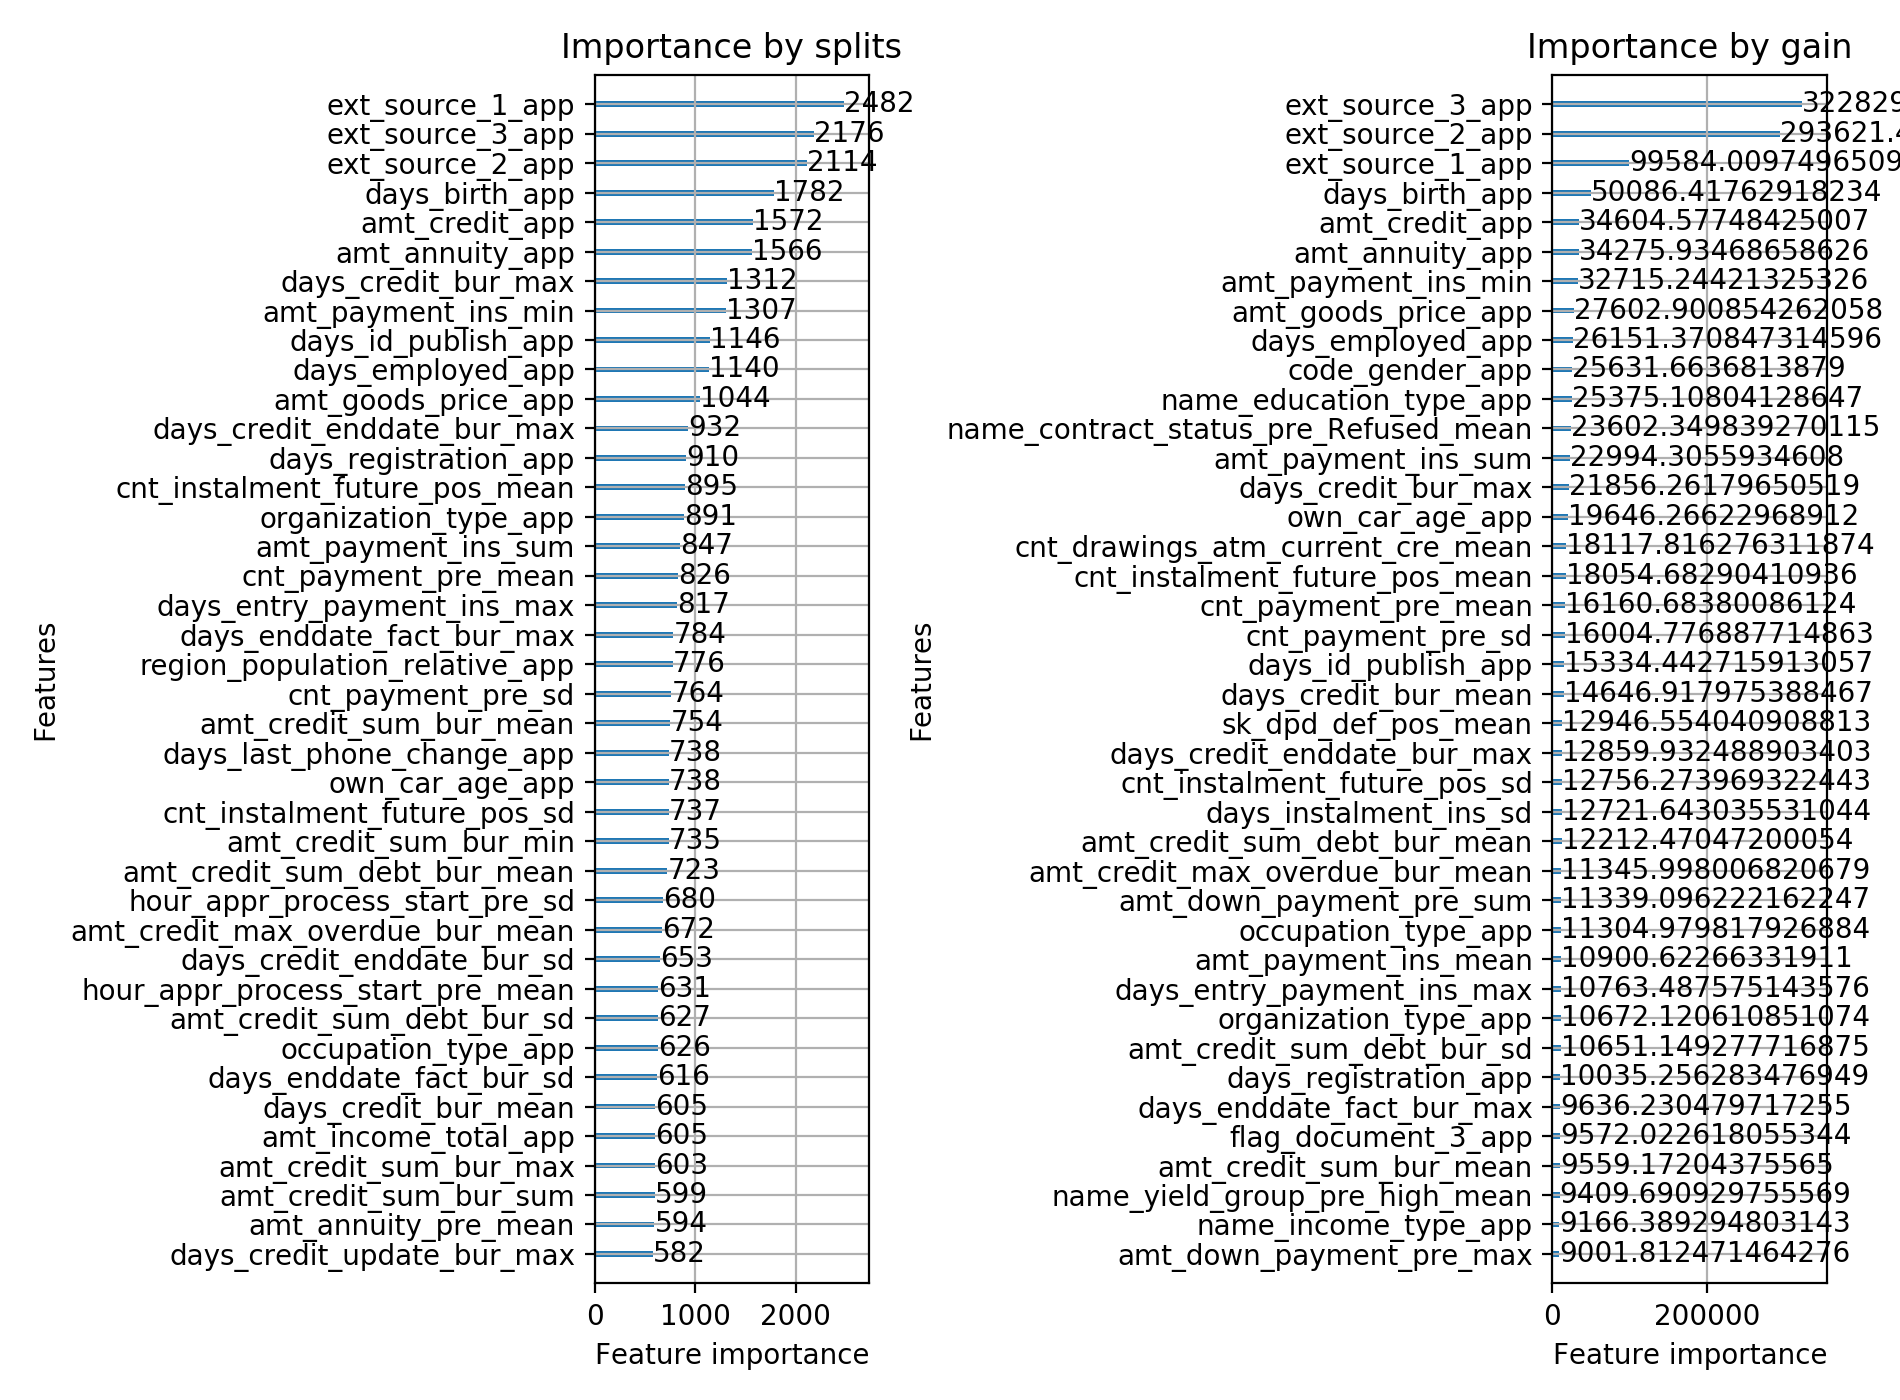

In [49]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[9.5, 7])
lgb.plot_importance(models_train, ax=ax, max_num_features=40, importance_type='split')
lgb.plot_importance(models_train, ax=ax1, max_num_features=40, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
# plt.savefig('feature_importance.png')